## Specify image size

In [1]:
cam_H, cam_W = 654, 1124

## First of all, we rectify stereo cameras and get new parameters for rectified camera

(<Axes: >, (0.0, 1.0, 0.0, 1.0), <matplotlib.image.AxesImage at 0x1d4348014d0>)

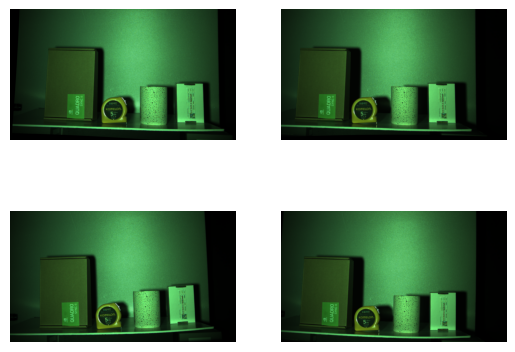

In [2]:
# Camera 1 is the left camera
# Extrinsic parameters (rotation.mat and translation.mat) are
# the extrinsic parameter of the right camera with respect to the
# right camera

import os
import glob
import numpy as np
import cv2
import scipy.io as io
import matplotlib.pyplot as plt

# Load images
cam1_img = cv2.imread(os.path.join("stereo_images", "cam1_img.png"))
cam2_img = cv2.imread(os.path.join("stereo_images", "cam2_img.png"))

# We use intrinsics and extrinsic acquired from Matlab's stereo rectification result
# Intrinsic parameters
cameraMatrix1 = io.loadmat(os.path.join("stereo_parameters", 'intrinsic_camera1.mat'))['K']
cameraMatrix2 = io.loadmat(os.path.join("stereo_parameters", 'intrinsic_camera2.mat'))['K']
distCoeffs1 = io.loadmat(os.path.join("stereo_parameters", 'distortion_camera1.mat'))['distortion']
distCoeffs2 = io.loadmat(os.path.join("stereo_parameters", 'distortion_camera2.mat'))['distortion']

# We use intrinsics and extrinsic acquired from Matlab's stereo rectification result
# Extrinsic parameters
R = io.loadmat(os.path.join("stereo_parameters", 'rotation.mat'))['R']
T = io.loadmat(os.path.join("stereo_parameters", 'translation.mat'))['T']

cameraMatrix1 = cameraMatrix1.astype(np.float64)
cameraMatrix2 = cameraMatrix2.astype(np.float64)
distCoeffs1 = distCoeffs1.astype(np.float64)
distCoeffs2 = distCoeffs2.astype(np.float64)
R = R.astype(np.float64)
T = T.astype(np.float64)

# Rectify camera and get new camera parameters
R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv2.stereoRectify(
cameraMatrix1, distCoeffs1,
cameraMatrix2, distCoeffs2,
(cam_H, cam_W), R, T.T)

# Save the camera parameters
np.save(os.path.join("rectified_parameters", 'cam1_R.npy'), R1)
np.save(os.path.join("rectified_parameters", 'cam2_R.npy'), R2)
np.save(os.path.join("rectified_parameters", 'cam1_P.npy'), P1)
np.save(os.path.join("rectified_parameters", 'cam2_P.npy'), P2)
np.save(os.path.join("rectified_parameters", 'Q.npy'), Q)

# Remap the images using rectified camera parameters
map1x, map1y = cv2.initUndistortRectifyMap(cameraMatrix1, distCoeffs1, R1, P1, (cam_W, cam_H), cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(cameraMatrix2, distCoeffs2, R2, P2, (cam_W, cam_H), cv2.CV_32FC1)
rectified_img1 = cv2.remap(cam1_img, map1x, map1y, cv2.INTER_LINEAR)
rectified_img2 = cv2.remap(cam2_img, map2x, map2y, cv2.INTER_LINEAR)

plt.subplot(221), plt.axis('off'), plt.imshow(cv2.cvtColor(rectified_img1, cv2.COLOR_BGR2RGB))
plt.subplot(222), plt.axis('off'), plt.imshow(cv2.cvtColor(rectified_img2, cv2.COLOR_BGR2RGB))
plt.subplot(223), plt.axis('off'), plt.imshow(cv2.cvtColor(cam1_img, cv2.COLOR_BGR2RGB))
plt.subplot(224), plt.axis('off'), plt.imshow(cv2.cvtColor(cam2_img, cv2.COLOR_BGR2RGB))

## Functions for depth map rectification, noise filtering, masking, and so on

In [3]:
import open3d as o3d 

def depth_map_to_point_cloud(depth_map, intrinsic=None):
    """
    Convert depth map to point cloud. If the depth map already has 
    unprojected (x,y,z) positions for each pixel, (in this case, keep param intrinsic None
    when call the function) the process becomes much simpler.
    :param depth_map: 
     If the depth map only have z value(depth) without (x, y) position of the unprojected point,
     The depth map must be an undistorted one (Use cv2.undistort or other method).
    :param intrinsic: Intrinsic parameters (focal length and principal point).
    :return: (Open3D point cloud object, point vectors)
    """
    if intrinsic is None: 
        mask1 = (depth_map[:,:,2] >= -np.inf) # Masking can be applied by replacing -np.inf.
        mask2 = (depth_map[:,:,2] <= np.inf)  # Masking can be applied by replacing np.inf.
        mask = mask1*mask2
        points = depth_map[mask==True]
    else:
        fx, fy, cx, cy = intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2]   # Focal lengths and principal point
        rows, cols = depth_map.shape
        xx, yy = np.meshgrid(np.arange(cols), np.arange(rows))
        zz = depth_map
        x = (xx - cx) * zz / fx
        y = (yy - cy) * zz / fy
        points = np.vstack((x.flatten(), y.flatten(), zz.flatten())).T
        
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    return point_cloud, points


def transform_point_cloud_to_other_camera(point_cloud, R, T):
    """
    Transform a coordinate of point cloud to the other camera's coordinate system.
    :param point_cloud: Point cloud from the original camera coordinate.
    :param extrinsics: Extrinsic parameters (rotation and translation) from original camera to other camera.
    :return: Transformed point cloud.
    """
    point_cloud.transform(np.vstack([np.hstack((R, T.reshape(-1, 1))), [0, 0, 0, 1]]))
    return point_cloud


def project_point_cloud_to_image_plane(point_cloud, intrinsic, H=None, W=None, distCoeffs=[0, 0, 0, 0]):
    """
    Refer to https://www.opencv.org.cn/opencvdoc/2.3.2/html/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html
    Project the point cloud onto the camera's image plane to get the depth map.
    Currently, this function can only deal with 4-th order radial distortion (ignore tangential and higher order radial distortion)
    Currently, this function has minor difference with the opencv's projection function when considering distortion
    No difference when do not using distortion (i.e. distCoeffs = [0, 0, 0, 0])
    :param point_cloud: point cloud in the camera's coordinate system.
    :param intrinsics_left: Intrinsic parameters of the camera.
    :return: Depth map.
    """
    fx, fy, cx, cy = intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2]
    k1, k2, k3, k4 = distCoeffs
    points = np.asarray(point_cloud.points)
    z = points[:, 2]
    x = points[:, 0] / (z+1e-20)
    y = points[:, 1] / (z+1e-20)
    r2 = x**2 + y**2
    r4 = r2 ** 2
    r6 = r2 ** 3
    xx = x*((1 + k1*r2 + k2*r4 + k3*r6)/(1 + k4*r2))
    yy = y*((1 + k1*r2 + k2*r4 + k3*r6)/(1 + k4*r2))
    u = fx * xx + cx # final project points' x position
    v = fy * yy + cy # final project points' y position

    if W is None: 
        W = int(np.max(u)) + 1 
    if H is None: 
        H = int(np.max(v)) + 1
    depth_map = np.zeros((H, W, 3))
    mask_horizontal = (0 <= u) * (u <= W-1)
    mask_vertical = (0 <= v) * (v <= H-1)
    mask = mask_horizontal * mask_vertical
    u_clipped = u[mask]
    v_clipped = v[mask]
    z_clipped = z[mask]
    depth_map[np.round(v_clipped).astype(int), np.round(u_clipped).astype(int)] = np.stack([x[mask], y[mask], z_clipped], axis=-1)
    # depth_map[v_clipped.astype(int), u_clipped.astype(int)] = z_clipped
    return depth_map


def depth_from_points(points_projected_uv, points_vector_xyz, W, H):
    """ 
    :param points_projected_xyz: shape = (n_points, 3).
    :param points_vector_xyz: point cloud vector before projection
    Construct depth map from 3d points resulting from cv2.projectPoints
    """
    depth_map = np.zeros((H, W, 3))
    u = points_projected_uv[:, 0]
    v = points_projected_uv[:, 1]
    mask_horizontal = (0 <= u) * (u <= W-1)
    mask_vertical = (0 <= v) * (v <= H-1)
    mask = mask_horizontal * mask_vertical
    x_clipped = u[mask]
    y_clipped = v[mask]
    xyz_clipped = points_vector_xyz[mask]
    depth_map[np.round(y_clipped).astype(int), np.round(x_clipped).astype(int)] = xyz_clipped
    return depth_map


def filter_rectification_noise(img):
    """ 
    Fill holes(pixel with zero depth) in the image with mean of adjacent pixel values
    param img: numpy image. (H, W, C)"""
    H, W = img.shape[0], img.shape[1]
    temp_img = np.array(img)
    zero_indices = np.where(img[:, :, 2] == 0)
    for (i, j) in zip(zero_indices[0], zero_indices[1]):
        adj_indicies = [(i, j-1), (i, j+1), (i-1, j), (i+1, j-1)]
        mean = 0
        count = 0
        for adj_i, adj_j in adj_indicies:
            if (adj_i >= H) or (adj_j >= W):
                continue 
            adj_pixel_value = img[adj_i, adj_j]
            adj_depth_value = adj_pixel_value[2]
            if not (adj_depth_value == 0):
                mean += adj_pixel_value 
                count += 1
        if count == 0:
            continue 
        mean /= count 
        temp_img[i, j] = mean
    return temp_img

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Rectify depth map

In [4]:
# The depth map is based on the left camera (cam1)
depth_map_cam1 = np.load("depth_map.npy")

R = np.load(os.path.join("rectified_parameters", "cam1_R.npy")) 
T = np.array([[0], [0], [0]])
P = np.load(os.path.join("rectified_parameters", "cam1_P.npy")) # We directly have projection have from the result of cv2.stereoRectify

point_cloud_cam1, point_cloud_vector_cam1 = depth_map_to_point_cloud(depth_map_cam1)
point_cloud_cam2 = transform_point_cloud_to_other_camera(point_cloud_cam1, R, T)
depth_map_cam2 = project_point_cloud_to_image_plane(point_cloud_cam2, P[:3,:3], depth_map_cam1.shape[0], depth_map_cam1.shape[1])
plt.imsave(os.path.join('rectified_stereo_images', 'depth_map_rectified.png'), np.clip(depth_map_cam2[:, :, 2], 0, 2000))
np.save(os.path.join('rectified_stereo_images', 'depth_map_rectified.npy'), depth_map_cam2)

# Remove hole from transformation and reprojection
depth_map_cam2_hole_removed = filter_rectification_noise(depth_map_cam2)
plt.imsave(os.path.join('rectified_stereo_images', 'depth_map_rectified_hole_removed.png'), 
           np.clip(depth_map_cam2_hole_removed[:, :, 2], 0, 2000))
np.save(os.path.join('rectified_stereo_images', 'depth_map_rectified_hole_removed.npy'), 
        depth_map_cam2)

## Inverse Rectification
##### We inverse-rectify rectified disparity map directly into the depth map of the original camera

In [5]:
R = np.load(os.path.join("rectified_parameters", "cam1_R.npy"))
P = np.load(os.path.join("rectified_parameters", "cam1_P.npy"))
T = np.array([[0.0], [0.0], [0.0]]) # Rectification does not include translation transformation

# Q is one of the outputs of cv2.stereoRectify, which is used to converts disparity map into depth
Q = np.load(os.path.join("rectified_parameters", "Q.npy")).astype(np.float32)

# inverse matrix. since we want inverse rectification
R = R.T
T = -T

# We need intrinsics and distortion coefficients of the original camera to project point clouds to the camera plane
cameraMatrix_original = io.loadmat(os.path.join("stereo_parameters", "intrinsic_camera1.mat"))['K'].astype(np.float32)
distCoeffs = io.loadmat(os.path.join("stereo_parameters", "distortion_camera1.mat"))['distortion'].astype(np.float32)

disparity_cam1 = abs(np.load(os.path.join('depth-map&disparity-map', "disparity_map_rectified.npy"))).astype(np.float32)
depth_map_cam1 = cv2.reprojectImageTo3D(disparity_cam1, Q)
point_cloud_cam1, point_cloud_cam1_vector = depth_map_to_point_cloud(depth_map_cam1)
point_cloud_cam2 = transform_point_cloud_to_other_camera(point_cloud_cam1, R, T)
point_cloud_cam2_vector = np.asarray(point_cloud_cam2.points)
point_cloud_cam2_xy, _ = cv2.projectPoints(point_cloud_cam1_vector, 
                                            R, T, 
                                            cameraMatrix_original,
                                            distCoeffs) # shape = (n_points, 1, 2)
depth_cam2 = depth_from_points(np.stack([point_cloud_cam2_xy[:, 0, 0], 
                                            point_cloud_cam2_xy[:, 0, 1]], axis=-1),
                                            point_cloud_cam2_vector,
                                            disparity_cam1.shape[1], 
                                            disparity_cam1.shape[0])
# Save
np.save(os.path.join('depth-map&disparity-map','inverse_rectified_depth.npy'), depth_cam2)
plt.imsave(os.path.join('depth-map&disparity-map','inverse_rectified_depth.png'), depth_cam2[:, :, 2])

# Remove hole from transformation and reprojection
depth_cam2_hole_removed = filter_rectification_noise(depth_cam2)

# Save
np.save(os.path.join('depth-map&disparity-map', 'inverse_rectified_depth_hole_removed.npy'), depth_cam2_hole_removed)
plt.imsave(os.path.join('depth-map&disparity-map', 'inverse_rectified_depth_hole_removed.png'), depth_cam2_hole_removed[:, :, 2])

## Depth map into Disparity map
#### To accurately convert depth map into dispiarty map, we need difference of principal points between two cameras (cx1-cx2 or cx2-cx1). 
#### However, when we convert depth map into the disparity map, the disparity maps are usually rectified one, therefore two cameras would have same principal points

In [6]:
principal_points_difference = 0

In [10]:
T = io.loadmat(os.path.join("stereo_parameters", "translation.mat"))["T"]

depth_map = np.load(os.path.join('depth-map&disparity-map', 'depth_map_rectified.npy'))[:, :, 2]

focal_length = np.load(os.path.join("rectified_parameters", 'cam1_P.npy'))[0][0]
baseline = np.sqrt(T[0][0]**2 + T[0][1]**2 + T[0][2]**2) # Rectification does not change translation between two cameras
disparity_map = focal_length * baseline / (depth_map + principal_points_difference)

np.save(os.path.join('depth-map&disparity-map', "depth_map_rectified_converted_to_disparity.npy"), disparity_map)
plt.imsave(os.path.join('depth-map&disparity-map', 'depth_map_rectified_converted_to_disparity.png'), np.clip(disparity_map, 0, 1000))

C:\Users\user\AppData\Local\Temp\ipykernel_19632\2133528833.py:7: RuntimeWarning: divide by zero encountered in divide
  disparity_map = focal_length * baseline / (depth_map + principal_points_difference)


## Disparity map into Depth map
#### To accurately convert disparity map into depth map, we need difference of principal points between two cameras (cx1-cx2 or cx2-cx1). 
#### However, when we convert disparity map into the depth map, the depth maps are usually rectified one, therefore two cameras would have same principal points

In [11]:
principal_points_difference = 0

In [13]:
T = io.loadmat(os.path.join("stereo_parameters", "translation.mat"))["T"]

disparity_map = np.load(os.path.join('depth-map&disparity-map', 'disparity_map_rectified.npy'))

focal_length = np.load(os.path.join("rectified_parameters", 'cam1_P.npy'))[0][0]
baseline = np.sqrt(T[0][0]**2 + T[0][1]**2 + T[0][2]**2) # Rectification does not change translation between two cameras
depth_map = focal_length * baseline / disparity_map + principal_points_difference

np.save(os.path.join('depth-map&disparity-map', "disparity_map_rectified_converted_to_depth.npy"), disparity_map)
plt.imsave(os.path.join('depth-map&disparity-map', 'disparity_map_rectified_converted_to_depth.png'), np.clip(disparity_map, 0, 1000))

## (Optional) Compute projector-camera correspondence error
#### Most of the code is brought from Heewoo
#### Depth estimated from Structured Light is used as GT. The GT might have some stripped pattern since acquired from the Structured Light, thus the loss have the stripped pattern.

In [16]:
def decode_calib(calib_path):
    fs = cv2.FileStorage(calib_path, cv2.FILE_STORAGE_READ)
    cam_shape_mat = fs.getNode('img_shape').mat().astype(np.int32)
    cam_shape = (cam_shape_mat[0][0], cam_shape_mat[1][0])
    cam_int = fs.getNode('cam_int').mat()
    cam_dist = fs.getNode('cam_dist').mat()
    proj_int = fs.getNode('proj_int').mat()
    proj_dist = fs.getNode('proj_dist').mat()
    cam_proj_rmat = fs.getNode('rotation').mat()
    cam_proj_tvec = fs.getNode('translation').mat()
    fs.release()
    return cam_int, cam_dist, proj_int, proj_dist, cam_proj_rmat, cam_proj_tvec, cam_shape

def conv2cam_coord(depth, cam_int, cam_dist, cam_shape):
    cam_h, cam_w = cam_shape[0], cam_shape[1]

    # make coordinate (cam_h, cam_w, (y, x))
    y_coords, x_coords = np.meshgrid(np.linspace(0, cam_h-1, cam_h), np.linspace(0, cam_w-1, cam_w), indexing='ij')
    coordinates = np.dstack((x_coords, y_coords))

    # camera distortion added
    coordinates = coordinates.reshape((1, -1, 2)).astype(np.float64)
    cam_dist = cam_dist[0][:4] # to fit in undistortPoints
    undistorted_coordinates = cv2.undistortPoints(coordinates, cam_int, cam_dist, P=cam_int)
    cam_pix = cv2.convertPointsToHomogeneous(undistorted_coordinates).reshape(cam_h, cam_w, 3)
    cam_int_inv = np.linalg.inv(cam_int)

    # image coordinate -> camera coordinate -> * depth 
    cam_mm = np.matmul(cam_int_inv, cam_pix.reshape(cam_h, cam_w, 3,1)[...,:,:])
    cam_depth = depth.reshape(cam_h, cam_w,1) * cam_mm.reshape(cam_h, cam_w,3) 

    # extend homogeneous 3D -> 4D
    cam_depth_flat = cam_depth.reshape((-1, 3)).astype(np.float32)
    cam_coord = cv2.convertPointsToHomogeneous(cam_depth_flat).reshape(cam_h, cam_w, 4)
    return cam_coord

def conv2proj_project(cam_coord, proj_int, proj_rmat, proj_tvec, proj_dist, cam_shape):
    cam_coord = cv2.convertPointsFromHomogeneous(cam_coord.reshape(-1, 4))
    proj_rvec, _ = cv2.Rodrigues(proj_rmat)
    proj_2d, _ = cv2.projectPoints(cam_coord, proj_rvec, proj_tvec, proj_int, proj_dist)
    proj_2d_reshaped = proj_2d.reshape(cam_shape[0], cam_shape[1], 2)
    proj_2d_reshaped_ret = np.zeros_like(proj_2d_reshaped)
    proj_2d_reshaped_ret[:, :, 0] = proj_2d_reshaped[:,:, 1]
    proj_2d_reshaped_ret[:, :,1] = proj_2d_reshaped[:,:, 0 ]
    return proj_2d_reshaped_ret

# get parameters for calibration
cam_int, cam_dist, proj_int, proj_dist, cam_proj_rmat, cam_proj_tvec, cam_shape =\
      decode_calib(os.path.join("projector_cam_parameters", 'calibration_propcam.xml'))

depth_gt = np.load("gt-depth-mm.npy")[:,:,2] # get z coord for depth. unit is mm.
depth_estimated = np.load(os.path.join('depth-map&disparity-map', "inverse_rectified_depth_hole_removed.npy"))[:, :, 2]

# The value (y, x) in proj_pix_distorted[r, c] is a position of the projector pixel corresponds to a pixel position (r, c) of the camera. 
cam_coord_distorted_gt = conv2cam_coord(depth_gt, cam_int, cam_dist, cam_shape)
cam_coord_distorted_estimated = conv2cam_coord(depth_estimated, cam_int, cam_dist, cam_shape)
proj_pix_distorted_gt = conv2proj_project(cam_coord_distorted_gt, proj_int, cam_proj_rmat, cam_proj_tvec, proj_dist, cam_shape)
proj_pix_distorted_estimated = conv2proj_project(cam_coord_distorted_estimated, proj_int, cam_proj_rmat, cam_proj_tvec, proj_dist, cam_shape)

# Calculate correspondence error
abs_corresponding_loss_y = abs(proj_pix_distorted_gt-proj_pix_distorted_estimated)[:, :, 0]
abs_corresponding_loss_x = abs(proj_pix_distorted_gt-proj_pix_distorted_estimated)[:, :, 1]
abs_corresponding_loss_xy = abs(abs_corresponding_loss_y) + abs(abs_corresponding_loss_x)

plt.imshow(abs_corresponding_loss_x, vmin=0, vmax=3, cmap='jet')
plt.axis('off')
plt.colorbar(fraction=0.03, pad=0.04)
plt.title('Correspondence error (pixel)', fontdict = {'fontsize' : 18})
plt.savefig(os.path.join('correspondence_loss', 'correspondence_x_loss.png'), bbox_inches='tight', dpi=400)
plt.clf()
plt.imshow(abs_corresponding_loss_y, vmin=0, vmax=3, cmap='jet')
plt.axis('off')
plt.colorbar(fraction=0.03, pad=0.04)
plt.title('Correspondence error (pixel)', fontdict = {'fontsize' : 18})
plt.savefig(os.path.join('correspondence_loss', 'correspondence_y_loss.png'), bbox_inches='tight', dpi=400)
plt.clf()
plt.imshow(abs_corresponding_loss_xy, vmin=0, vmax=3, cmap='jet')
plt.axis('off')
plt.colorbar(fraction=0.03, pad=0.04)
plt.title('Correspondence error (pixel)', fontdict = {'fontsize' : 18})
plt.savefig(os.path.join('correspondence_loss', 'correspondence_xy_loss.png'), bbox_inches='tight', dpi=400)
plt.clf()

np.save(os.path.join('correspondence_loss', "correspondence_x_loss"), abs_corresponding_loss_x)
np.save(os.path.join('correspondence_loss', "correspondence_y_loss"), abs_corresponding_loss_y)
np.save(os.path.join('correspondence_loss', "correspondence_xy_loss"), abs_corresponding_loss_xy)

<Figure size 640x480 with 0 Axes>